<a href="https://colab.research.google.com/github/Renshui-MC/DeepLearning-ZerosToGans/blob/main/logistic%20regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Working with Images & Logistic Regression in PyTorch**

+ use linear regression to do **image classification**
+ instead of taking numbers, we take **images** as input features and determine what digits the images represent
+ `torchvision` is a package that contains `datasets` module from which we import `MNIST` class

In [ ]:
import torch
import torchvision
from torchvision.datasets import MNIST

Let's download training datasets

+ instantiate the class `MNIST`
+ the `dataset` object is already converted to a `PyTorch` type object
+ the `dataset` object can access the methods defined under `MNIST`
+ `Download = True` checks if the data are already downloaded
+ it downloads the data to the `data/` directory 


In [ ]:
dataset = MNIST(root='data/', download=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



check how many elements/samples that the dataset contains

In [ ]:
len(dataset)

60000

The dataset has **60,000 images** that we'll use to **train the model**. There is also an additional **test set** of **10,000 images** used for **evaluating models** and reporting **metrics** in papers and reports. 

+ We can create the test dataset using the `MNIST` class by passing `train=False` to the constructor.

In [ ]:
test_dataset = MNIST(root='data/', train=False)
len(test_dataset)

10000

Let's look at a **sample element** from the **training dataset**.

+ `PIL` is the [`Pillow`](https://pillow.readthedocs.io/en/stable/) library. `.image` module and `.image` class.
+ `5` is the label for the image (because we have $0,..,9$)
+ each image has $28 \times 28$ pixels

In [ ]:
dataset[0]

(<PIL.Image.Image image mode=L size=28x28 at 0x7FE68B250DC0>, 5)

we can view this image using `matplotlib` library. Specifically, we want `pyplot` module from this library.

+ very useful statement ([magic command ](https://ipython.readthedocs.io/en/stable/interactive/magics.html )) `%matplotlib inline` allows you to retain the image within the current notebook. Otherwise, the image will pop up once and then disappears after you close the notebook.

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline 

Let's look at a couple of images from the dataset.

+ `dataset[0]` indicates the first element of the dataset
+ `cmap`: color map
+ note that label $5$ just corresponds number $5$



Label: 5


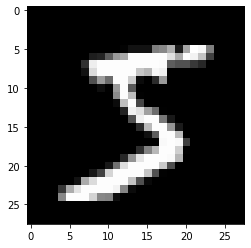

In [ ]:
image, label = dataset[0]

plt.imshow(image, cmap='gray')
print('Label:', label)

Label: 0


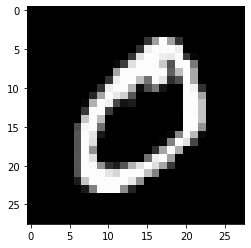

In [ ]:
image, label = dataset[1]

plt.imshow(image, cmap='gray')
print('Label:', label)

`PyTorch` doesn't know how to work with images. We need to **convert the images into tensors**. We can do this by **specifying a transform while creating our dataset**.

+ `torchvision` library
+ `transorm` module
+ use `MNIST` class
+ set `train=True` for training dataset
+ `transform=transforms.ToTensor()` convert the image into tensor as we load the images

In [ ]:
import torchvision.transforms as transforms

In [ ]:
# MNIST dataset (images and labels)
dataset = MNIST(root='data/', train=True, transform=transforms.ToTensor())

Let's first look at the shape of the converted tensor:

+ `[1, 28, 28]` means every image is a three dimensional tensor
+ every image is a $28 \times 28$ matrix (color pixels)
+ the first dimension `1` tracks **color channels**. In this case, `grayscale` is used. Typically, we have images with **three color channels**: **red, green and blue (RGB).**
+ second and third dimensions ($28 \times 28$) represent pixels along the **height and width** of the image, respectively. For each dataset element, we have a 28 x 28 matrix for each image
+ 5 is the label of the image
+ **Note that there are only $10$ distinct labels, i.e., 0,..,9 for all these images** 

In [ ]:
img_tensor, label = dataset[0]
print(img_tensor.shape, label)

torch.Size([1, 28, 28]) 5


In [ ]:
img_tensor, label = dataset[30000]
print(img_tensor.shape, label)

torch.Size([1, 28, 28]) 3


In [ ]:
img_tensor, label = dataset[30200]
print(img_tensor.shape, label)

torch.Size([1, 28, 28]) 1


Now let's look at some sample values inside the tensor

+ in order `[color channel index, rows indices, columns indices]`. 
+ Since we only have one color channel (recall `[1, 28, 28]` where $1$ indicates only one color channel available), we only have `index = 0` to get the first color channel. 
+ `10:15` indicates that $5 \times 5$ pixels out of $28 \times 28$ pixels are interested 
+ The values range from $0$ to $1$
+ $0$ represents black, and $1$ white, and the values in between different shades of grey. 

In [ ]:
print(img_tensor[0,10:15,10:15])
print(torch.max(img_tensor), torch.min(img_tensor))

tensor([[0.0000, 0.0000, 0.5490, 0.9961, 0.8000],
        [0.0000, 0.0000, 0.5490, 0.9961, 0.8000],
        [0.0000, 0.0000, 0.5490, 0.9961, 0.8000],
        [0.0000, 0.0000, 0.5490, 0.9961, 0.8000],
        [0.0000, 0.0000, 0.5490, 0.9961, 0.8000]])
tensor(1.) tensor(0.)


We can also plot the tensor as an image using `plt.imshow`

+ we need to pass a color map (`cmp=gray`)
+ pass 28 x 28 matrix to `plt.imshow`

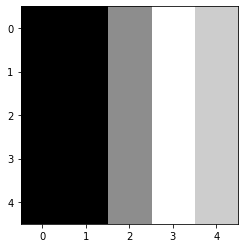

In [ ]:
# Plot the image by passing in the 28x28 matrix
plt.imshow(img_tensor[0,10:15,10:15], cmap='gray');

##**Training and Validation Datasets**

While building real-world machine learning models, it is quite common to split the dataset into three parts:

1. **Training set** - used to train the model, i.e., compute the loss and adjust the model's weights using gradient descent.
2. **Validation set** - used to evaluate the model during training, adjust hyperparameters (learning rate, etc.), and pick the best version of the model.
3. **Test set** - used to compare different models or approaches and report the model's final accuracy.

In the MNIST dataset, there are 60,000 training images and 10,000 test images. The test set is **standardized** so that different researchers can report their models' results against the same collection of images. 

+ test set is not for training

Since there's no predefined validation set, we must manually split the **60,000 images into training and validation datasets**. 

* Let's set aside 10,000 randomly chosen images for validation. We can do this using the `random_spilt` method from PyTorch.

+ from the dataset ($60000$) we want 

+ $50000$ for training dataset (`train_ds`) and 

+ $10000$ for validation dataset (`val_ds`)





In [ ]:
from torch.utils.data import random_split

train_ds, val_ds = random_split(dataset, [50000, 10000])
len(train_ds), len(val_ds)

(50000, 10000)

###**Randomization for training dataset `shuffle=True`**
It's essential to choose a **random sample** for creating a validation set. Training data is often sorted by the target labels, i.e., images of 0s, followed by 1s, followed by 2s, etc. 

+ If we create a validation set using the last 20% of images, it would only consist of 8s and 9s. 

+ In contrast, the training set would contain no 8s or 9s. 

As the result, the training set and validation set are **completely separate**,and such a training-validation would make it impossible to train a useful model.

We can now create data loaders to help us load the data in batches. We'll use a batch size of 128.

+ `torch.utils.data`: `torch` library, `utils` package, `data` module, and `DataLoader` class

+ we want to split the full dataset into batches because it is much more efficient to train our data. Otherwise, it will be extremely slow

+ `shuffle=True` to let batches generated randomly in each epoch so that the model is generalized

+ `train_loader` contains both input batches and output batches

+ `val_loader` also contains input and output batches, but not randomized because it is used only to report the final result


In [ ]:
from torch.utils.data import DataLoader

batch_size = 128

train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size)

#**Model**
Now that we have prepared our data loaders, we can define our model.

* A **logistic regression** model is almost identical to a linear regression model. It contains weights and bias matrices, and the output is obtained using simple matrix operations (`pred = x @ w.t() + b`). 

* As we did with linear regression, we can use `nn.Linear` to create the model instead of manually creating and initializing the matrices.

* Since `nn.Linear` expects each training example to be a vector, each three-dimensional (`1x28x28`) image tensor is _flattened_ into a vector of size 784 `(28*28)` inputs before being passed into the model. 

1. we note that tensor always refers to high-dimensional datasets, while vector refers to one-dimensional dataset

2. recall that we have only three input features (temperature, rainfall, humidity) for the linear regression model. However, we have **$\mathbf{784}$ input features**, 

3. which represent **pixel intensities at different positions within the image** (_The intensity value for each pixel is a single value for a gray-level image, or three values for a color image (red, blue, green)._), i.e., a value from $0 - 1$

* The output for each image is a vector of size $10$ (because we are dealing with numbers of 0 to 9), with each element signifying the probability of a particular target label (i.e., $0$ to $9$). **The predicted label for an image is simply the one with the highest probability**.

1. recall that we have only $2$ predicted targets for the linear regression model. Here we have $10$ predicted targets. Instead of giving a number, **logistic regression** model gives a **probability of a particular label** 

\\

**Importantly, we note that the `PyTorch` logistic regression model is exactly same as the `PyTorch` linear regression model  (nn.Linear(number, number)). The only difference is the current model has a much larger size. This indicates the importance of correctly specifying your input feature and output target sizes.**

In [ ]:
import torch.nn as nn

input_size = 28*28
num_classes = 10

# Logistic regression model
model = nn.Linear(input_size, num_classes)

Recall that `nn.Linear` automatically outputs weights and biases for us. Let's take a look at them:

+ number of weights: number of inputs ($784$) x number of targets ($10$)
+ total of $7850$ parameters here ($7840$ weights and $10$ biases)
+ $7840$ weights because we have $10$ sets of $784$ weights for the $10$ classes/outputs


In [ ]:
print(model.weight.shape)
model.weight

torch.Size([10, 784])


Parameter containing:
tensor([[-0.0209, -0.0148, -0.0051,  ..., -0.0306,  0.0300,  0.0080],
        [-0.0046,  0.0189,  0.0328,  ..., -0.0207,  0.0285,  0.0111],
        [-0.0176,  0.0149,  0.0092,  ...,  0.0165, -0.0215, -0.0357],
        ...,
        [ 0.0097,  0.0246, -0.0195,  ...,  0.0078, -0.0277,  0.0054],
        [-0.0008,  0.0062, -0.0279,  ..., -0.0019,  0.0351,  0.0333],
        [-0.0357,  0.0009, -0.0063,  ..., -0.0064,  0.0346,  0.0168]],
       requires_grad=True)

In [ ]:
print(model.bias.shape)
model.bias

torch.Size([10])


Parameter containing:
tensor([-0.0314,  0.0335, -0.0061,  0.0039, -0.0141, -0.0210,  0.0355,  0.0081,
         0.0320,  0.0085], requires_grad=True)

Let's try and generate some outputs using our model. We'll take the first batch of $100$ images from our dataset and pass them into our model.

+ `for` loop iterates through all batches
+ `images` are inputs
+ `labels` are outputs
+ `break` ensures only the first batch is printed


In [ ]:
#iterate through the 3 batches (batch size  = 128)

for images, labels in train_loader:
    print(labels)
    print(images.shape)
    outputs = model(images)
    print(outputs)
    break

tensor([7, 8, 4, 6, 9, 4, 6, 8, 4, 1, 4, 5, 1, 0, 0, 1, 6, 9, 6, 7, 2, 4, 1, 8,
        0, 9, 2, 8, 8, 8, 3, 3, 1, 6, 8, 1, 0, 1, 1, 8, 0, 6, 3, 8, 7, 4, 8, 8,
        5, 4, 6, 4, 0, 2, 3, 0, 4, 7, 1, 4, 7, 6, 3, 3, 0, 3, 6, 1, 7, 1, 0, 5,
        7, 4, 9, 6, 2, 6, 5, 8, 9, 8, 2, 8, 6, 7, 7, 2, 0, 5, 6, 6, 5, 7, 2, 5,
        6, 1, 6, 5, 9, 9, 9, 8, 2, 8, 2, 6, 4, 8, 8, 5, 5, 7, 3, 4, 3, 3, 3, 4,
        1, 9, 6, 0, 4, 5, 9, 0])
torch.Size([128, 1, 28, 28])


RuntimeError: ignored

The error is due to the **incorrect shape** used: `torch.Size([128, 1, 28, 28])`, where $128$ is the batch size, $1$ indicates only one color label used, $28$, $28$ represent hight and width of a **two dimensional matrix** of an image. 

\\

It indicates that we are dealing with a three-dimensional image tensor `[1, 28, 28]`, rather than a **single-dimensional** vector of size $784$. As mentioned earlier, we have to **flatten the multi-dimensional tensors into single-dimensional vectors**. 


+ We'll use the `.reshape` method of a tensor, 
+ which will allow us to efficiently 'view' each image as a flat vector without really creating a copy of the underlying data.

see the reshape example below
+ $128$ represents the batch size
+ $784$ represents the vector size 

In [ ]:
images.shape

torch.Size([128, 1, 28, 28])

In [ ]:
images.reshape(128,784).shape

torch.Size([128, 784])

While, `reshape` is not included in the `PyTorch` logistic regression model originally

To include this additional functionality within our model, we need to define a custom model by extending the `nn.Module` class from `PyTorch`

A class in Python provides a "blueprint" for creating objects, which once instantiated can access the attributes and methods defined in the class.

### **Extend  the `nn.Module` class via Inheritance**

Recall: given the batch size (128) and training dataset (50000), `Dataloader` class can split the training data into batches, i.e., a `train_loader` object that contains both input and output batches. However, input batch is a three-dimensiional tensor which is not compatible with the `nn.linear` class. Therefore, our current goal is to convert the high-dimensional tensor into a **one-dimensional** vector so that it can be successfully used in the `nn.linear` `PyTorch` model to train the weights and biases.

\\

*Classes* can also build upon or _extend_ the functionality of existing classes. Let's extend the `nn.Module` class from PyTorch to define a custom model.

\\

**Our goal is to reshape/flatten a multi-dimensional tensor ([128, 1, 28, 28]) into a one-dimensional vector with the shape [1, size]**.

\\

+ `nn.Module` is the base class for all neural network modules. Your models should also subclass this class.


+ you must initialize the exisiting/old `super().__init()__()` in the parent class. Otherwise, your modified/new version of the `__init()__` method is half-initialized and everything will break!

+ `nn.Linear` is a `PyTorch` class that takes the **batch size (number of training examples or features)** and the **size of the flattened one-dimensional vector** as inputs. Then it outputs weights and biases (check through `.parameters`) via constructor `self.linear` (**Note that `nn.Linear` requires ONLY sizes of tensors. There is no need for the actual elements of the tensors!** It trains the weights and biases with a correct shape of matrix defined.)

+ the `forward` method takes the **original multi-dimensional tensor** as an input, and then, reshape it into a **Two-dimensional tensor [batch size, 1d vector size]** 
+ when you pass a actual two-dimension tensor to `nn.linear` model, it will take the size inofrmation of the tensor only

+ `xb.reshape(-1, 28*28(784))` indicates to `PyTorch` that we want the `xb` tensor to be a two-dimensional tensor. You only need the length along the 2nd dimension ($784$), and $-1$ lets `PyTorch` **automatically** compute the second dimension for you 

+ `out` contains weights and biases
+ `model = MnistModel()` creates an object named "model", and here it has NOT been successfully instantiated until we pass data to it, e.g., `model(images)` 





In [ ]:
class MnistModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, num_classes)
        
    def forward(self, xb):
        print('xb size: ',xb.shape)
        xb = xb.reshape(-1, 784)
        out = self.linear(xb)
        return out
    
model = MnistModel()

In [ ]:
model.linear # note model function here is the older version! not the new model defined above

Linear(in_features=784, out_features=10, bias=True)

In [ ]:
print(model.linear.weight.shape, model.linear.bias.shape)
list(model.parameters())

torch.Size([10, 784]) torch.Size([10])


[Parameter containing:
 tensor([[-0.0010,  0.0349, -0.0064,  ...,  0.0244, -0.0102,  0.0301],
         [-0.0158, -0.0194,  0.0115,  ..., -0.0176, -0.0350, -0.0114],
         [ 0.0154,  0.0351,  0.0296,  ...,  0.0079, -0.0341,  0.0033],
         ...,
         [ 0.0129, -0.0129, -0.0317,  ..., -0.0176, -0.0251,  0.0220],
         [ 0.0320, -0.0131, -0.0088,  ..., -0.0273, -0.0024, -0.0091],
         [ 0.0141, -0.0332,  0.0054,  ...,  0.0264,  0.0190, -0.0354]],
        requires_grad=True), Parameter containing:
 tensor([-0.0270,  0.0251,  0.0108,  0.0318, -0.0107, -0.0208,  0.0246,  0.0006,
          0.0095, -0.0053], requires_grad=True)]

now we pass images (multi-dimensional tensor) to the "model" object to test if it gives us correct outputs without errors:

In summary, we need to go through the following procedures for training:

+ recall there are only `0,..,9` labels for all images
+ every output (one image) contains $10$ probabilities to indicate how how much probability that the images represent label $0$,...,$9$
+ `outputs[:2]` first two outputs will be printed
+ `images` tensor contains pixels with digits from $0$ to $1$ for each tensor element
+ then with reshaped `images` (1d vector), `model(images)` (`nn.linear`) will give you the `outputs` with probabilities and corresponding labels of each image
+ due to unrealistic negative probabilities that appear in our outputs, we need to use the `softmax` (`torch.nn.functional.softmax`) function to make probabilities realistic: from $0$ to $1$
+ finally we pick the element for each row with the highest probability as the output (of course we need to train the weights and biases through gradient descent)


In [ ]:
for images, labels in train_loader:
    print(images.shape)
    outputs = model(images)
    break
print('images.shape :', images.shape)
print('labels.shape :', labels.shape)
print('outputs.shape : ', outputs.shape)
print('Sample outputs :\n', outputs[:2].data)
#print('images :\n', images[:2].data[0])

torch.Size([128, 1, 28, 28])
images.shape : torch.Size([128, 1, 28, 28])
labels.shape : torch.Size([128])
outputs.shape :  torch.Size([128, 10])
Sample outputs :
 tensor([[-0.0219, -0.2120,  0.0716,  0.2281, -0.0118, -0.3503,  0.1161, -0.0606,
         -0.1697, -0.0079],
        [ 0.2213, -0.1737,  0.0557, -0.4354,  0.0082, -0.3196,  0.1359, -0.3471,
         -0.2758, -0.2522]])


However, it is clear that we got some negative probabilities which are not physically realistic. In addition, we have to ensure that the sum of all $10$ probabilities is equal to $1$ for every image.


To convert the output rows into true probabilities, 

+ positive ($e^{y_{i}}$)
+ added up to $1$ ($\frac{e^{y_i}}{Σe^{y_j}}$)

we use the softmax function, which has the following formula:

![softmax](https://i.imgur.com/EAh9jLN.png)


![](https://www.montereyinstitute.org/courses/DevelopmentalMath/COURSE_TEXT2_RESOURCE/U18_L1_T1_text_final_6_files/image001.png)

1. First, we replace each element `yi` in an output row by `e^yi`, making all the elements positive. 


2. Then we divide them by their sum to ensure that they add up to 1. The resulting vector can thus be interpreted as probabilities.

we'll use the implementation that's provided within `PyTorch` because it works well with multidimensional tensors (a list of $128$ output rows in our case).

See manually implement the softmax function below:

In [ ]:

#https://treyhunner.com/2016/04/how-to-loop-with-indexes-in-python/
num = torch.exp(outputs)
den = torch.sum(num,1)



The softmax function is included in the `torch.nn.functional` module and requires us to specify a dimension along which the function should be applied.

In [ ]:
import torch.nn.functional as F

In [ ]:
outputs[:2]

tensor([[-0.2303,  0.1272,  0.0104, -0.1469,  0.1111, -0.6265, -0.2407, -0.4717,
         -0.5755, -0.2607],
        [-0.4706,  0.0601, -0.0482, -0.0476,  0.3411, -0.2703, -0.1155,  0.0112,
         -0.0941,  0.0641]], grad_fn=<SliceBackward0>)

to use `softmax` we need to specify the dimension `dim` the softmax is going to be applied. 

+ We know the dimension of `output` is $[128, 10]$. 
+ the corresponding indices of rows and columns are `[0,1]`
+ `softmax` needs to be applied to the columns only, therefore `dim = 1`. Keep in mind that `softmax` will deal with all data no matter which dimension you give. But does matter which dimension you give to generate correct results. For example, it does not make sense to add columns ($128$ training examples) up to give a probability of $1$ 
+ `item()` method is to convert a **one element** (must be a one  element!) tensor (e.g., 1 x 10) to scalars


In [ ]:
# Apply softmax for each output row
probs = F.softmax(outputs, dim=1)

# Look at sample probabilities (first two rows)
print("Sample probabilities:\n", probs[:2].data)

# Add up the probabilities of an output row
print("Sum: ", torch.sum(probs[127]).item())

Sample probabilities:
 tensor([[0.0969, 0.1385, 0.1232, 0.1053, 0.1363, 0.0652, 0.0959, 0.0761, 0.0686,
         0.0940],
        [0.0648, 0.1101, 0.0988, 0.0989, 0.1459, 0.0792, 0.0924, 0.1049, 0.0944,
         0.1106]])
Sum:  0.9999999403953552


Now our **goal** is to pick the index of the output rows with the highest probability for each image as the predicted labels. We can do this using `torch.max`, which returns each row's **largest element** and the **corresponding probability**.

+ the predicted labels (`preds_labels`) for the **first batch (128)** of training images. Let's compare them with the actual lables.

+ Most of the **predicted labels** are different from the **actual labels**. That's because we have started with randomly initialized weights and biases. 

+ We need to train the model, i.e., adjust the weights using gradient descent to make better predictions.

In [ ]:
max_probs, preds_labels = torch.max(probs, dim=1)
print(preds_labels)
print(max_probs)
print('Max_probs size: ',max_probs.shape, 'and preds size: ', preds_labels.shape)

tensor([1, 4, 6, 7, 4, 1, 6, 6, 3, 4, 4, 3, 2, 1, 0, 1, 1, 1, 4, 4, 6, 1, 4, 9,
        6, 7, 2, 6, 6, 4, 6, 4, 1, 6, 6, 6, 2, 4, 7, 9, 4, 0, 3, 9, 9, 3, 4, 4,
        6, 9, 9, 3, 6, 6, 6, 4, 1, 6, 6, 2, 4, 9, 6, 4, 6, 0, 6, 6, 4, 2, 2, 6,
        7, 3, 1, 9, 6, 3, 1, 4, 3, 0, 6, 6, 2, 6, 6, 0, 1, 1, 4, 3, 4, 4, 2, 6,
        6, 9, 4, 1, 0, 4, 4, 9, 4, 1, 2, 4, 7, 9, 2, 9, 4, 6, 1, 4, 6, 6, 6, 1,
        1, 9, 3, 1, 6, 0, 6, 4])
tensor([0.1385, 0.1459, 0.1277, 0.1576, 0.1428, 0.1138, 0.1180, 0.1266, 0.1379,
        0.1197, 0.1298, 0.1322, 0.1279, 0.1439, 0.1347, 0.1287, 0.1194, 0.1277,
        0.1609, 0.1588, 0.1372, 0.1450, 0.1469, 0.1281, 0.1282, 0.1375, 0.1566,
        0.1298, 0.1337, 0.1563, 0.1375, 0.1230, 0.1282, 0.1122, 0.1182, 0.1435,
        0.1275, 0.1459, 0.1180, 0.1142, 0.1418, 0.1427, 0.1305, 0.1416, 0.1263,
        0.1266, 0.1297, 0.1539, 0.1328, 0.1421, 0.1392, 0.1412, 0.1210, 0.1258,
        0.1267, 0.1359, 0.1380, 0.1333, 0.1313, 0.1374, 0.1446, 0.1174, 0.1348,
       

In [ ]:
labels

tensor([0, 4, 9, 4, 0, 1, 9, 7, 6, 9, 3, 6, 3, 4, 5, 1, 4, 7, 0, 0, 8, 5, 0, 6,
        1, 0, 8, 4, 1, 6, 1, 5, 0, 2, 4, 3, 5, 6, 2, 9, 6, 5, 4, 6, 2, 1, 8, 9,
        8, 7, 6, 5, 9, 1, 8, 8, 5, 2, 8, 3, 0, 7, 4, 0, 8, 3, 1, 1, 8, 3, 5, 1,
        4, 9, 5, 7, 8, 2, 8, 4, 6, 7, 9, 8, 5, 1, 1, 4, 4, 9, 8, 6, 9, 3, 3, 1,
        1, 9, 5, 9, 9, 4, 0, 2, 9, 9, 1, 5, 6, 6, 2, 7, 4, 1, 9, 1, 2, 1, 1, 1,
        6, 7, 9, 5, 7, 7, 1, 5])

## **Evaluation Metric and Loss Function**

Just as with linear regression, we need a way to evaluate how well our model is performing. A natural way to do this would be to find the percentage of labels that were predicted correctly, i.e,. the **accuracy** of the predictions. 

+ number of correctly predicted labels/batch size (128)
+ we just introduced `torch.max(outputs, dim=1)` that uses the `outputs` (contains both probabilities and corresponding labels/indices) to pick the maximum probability values. Note that we used `torch.max(probs, dim=1)` where `probs` has been well converted to realistic probabilities through `sofmax()` function e.g, from $0$ to $1$, as an example. Note that we don't need to apply `softmax()` to the outputs here since its results have the same relative order. This is because `e^x` is an increasing function, i.e., if `y1 > y2`, then `e^y1 > e^y2`. The same holds after averaging out the values to get the softmax.

+ boolean type (`==` operator): $0$ for false and $1$ for true. Therefore, `torch.sum(preds_labels == labels).item()` will yield the number of correct predictions
+ `_,pred_labels` means we are only interested in labels NOT probabilities, `len(preds_labels)` is the batch size
+ note that `torch.max()` function is not continous, and hence, cannot be used as a **cost function** 

In [ ]:
#outputs contains: 1) labels/indices 2) probabilities
torch.max(outputs,dim=1)

torch.return_types.max(
values=tensor([ 0.1272,  0.3411,  0.0911,  0.3403,  0.1534,  0.1037,  0.2053,  0.2921,
         0.2032,  0.1897,  0.1529,  0.1839,  0.1042,  0.2754,  0.2010,  0.2195,
         0.0904,  0.2091,  0.3326,  0.2919,  0.2919,  0.2749,  0.1765,  0.2192,
         0.2201,  0.2192,  0.3867,  0.2861,  0.2691,  0.3327,  0.2880,  0.1864,
         0.0664, -0.0264,  0.1473,  0.2142,  0.1693,  0.2537,  0.0387,  0.0133,
         0.1973,  0.2553,  0.2596,  0.3329,  0.1632,  0.2454,  0.1802,  0.2767,
         0.3060,  0.1916,  0.1561,  0.3097,  0.1977,  0.1846,  0.1795,  0.3088,
         0.3888,  0.2618,  0.2024,  0.1546,  0.2538,  0.1446,  0.2968,  0.1924,
         0.3743,  0.0984,  0.2524,  0.1912,  0.0920,  0.0485,  0.1894,  0.3060,
         0.1499,  0.1994,  0.3399,  0.2580,  0.3230,  0.1020,  0.1510,  0.1398,
         0.1692,  0.1858,  0.1348,  0.1607,  0.3790,  0.2563,  0.2420,  0.2750,
         0.3018,  0.3079,  0.4657,  0.2490,  0.1628,  0.1229,  0.3343,  0.1306,
         

In [ ]:
#check how many correct predictions out of the batch size (128)
torch.sum(preds_labels == labels)

tensor(10)

In [ ]:
def accuracy(outputs, labels):
    _, preds_labels = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds_labels == labels).item() / len(preds_labels))

Accuracy is an excellent way for us (humans) to evaluate the model. However, we can't use it as a loss function for optimizing our model using gradient descent for the following reasons:

1. It's not a **differentiable function**. `torch.max` and `==` are both **non-continuous and non-differentiable operations**, so we can't use the accuracy for computing gradients w.r.t the weights and biases.

2. It doesn't take into account the actual probabilities predicted by the model, so it can't provide sufficient feedback for incremental improvements. 

For these reasons, accuracy is often used as an **evaluation metric** for classification, but not as a loss function. A commonly used loss function for classification problems is the **cross-entropy**, which has the following formula:

![cross-entropy](https://i.imgur.com/VDRDl1D.png)

While it looks complicated, it's actually quite simple:

* For **each output row**, pick the predicted probability for the correct label. E.g., if the predicted probabilities for an image are `[0.1, 0.3, 0.2, ...]` and the correct label is `1`, we pick the corresponding element `0.3` and ignore the rest. 

* Then, take the [logarithm](https://en.wikipedia.org/wiki/Logarithm) of the picked probability. If the probability is high, i.e., close to 1, then its logarithm is a very **small negative value**, close to 0. And if the probability is low (close to 0), then the logarithm is a **very large negative value**. We also multiply the result by $-1$, which results is a **large postive value of the loss for poor predictions**.

![](https://www.intmath.com/blog/wp-content/images/2019/05/log10.png)

* Finally, take the average of the cross entropy across all the output rows (every row has one value after cross entropy) to get the **overall loss** for a batch of data.

Unlike accuracy, **cross-entropy is a continuous and differentiable function**. It also provides useful feedback for incremental improvements in the model (a slightly higher probability for the correct label leads to a lower loss). These two factors make cross-entropy a better choice for **the loss function**.


Let's calculate the accuracy of the current model on the first batch of data.

In [ ]:
accuracy(outputs, labels)

tensor(0.0781)


As you might expect, `PyTorch` provides an efficient and tensor-friendly implementation of cross-entropy as part of the `torch.nn.functional` package. Moreover, it also performs `softmax` internally, so we can directly pass in the model's outputs without converting them into realistic probabilities.

\\

We know that **cross-entropy** is the negative logarithm of the predicted probability of the correct label averaged over all training samples. Therefore, one way to interpret the resulting number e.g. `2.23` is to look at `e^-2.23` which is around `0.1` as the predicted probability of the correct label, on average. **The lower the loss, The better the model.**

In [ ]:
loss_fn = F.cross_entropy

note that loss is a scalar value, not a tensor. The lower the loss, The better the model.

In [ ]:
# Loss for current batch of data
loss = loss_fn(outputs, labels)
print(loss)

tensor(2.3433, grad_fn=<NllLossBackward0>)


## **Training the model**

Now that we have defined the **data loaders, model, loss function and optimizer**, we are ready to train the model. The training process is identical to linear regression, with the addition of a "validation phase" to evaluate the model in each epoch. Here's what it looks like in pseudocode:

```
for epoch in range(num_epochs):
    # Training phase
    for batch in train_loader:
        # Generate predictions
        # Calculate loss
        # Compute gradients
        # Update weights
        # Reset gradients
    
    # Validation phase
    for batch in val_loader:
        # Generate predictions
        # Calculate loss
        # Calculate metrics (accuracy etc.)
    # Calculate average validation loss & metrics
    
    # Log epoch, loss & metrics for inspection
```

Some parts of the training loop are **specific** to the problem we're solving (e.g. loss function, metrics etc.) whereas others are **generic** and can be applied to any deep learning problem. 

We'll include the **problem-independent parts** within a function called `fit`, which will be used to train the model. The **problem-specific parts** will be implemented by adding new methods to the `nn.Module` class.

+ The `fit` function records the validation loss and metric from each epoch. It returns a history of the training, useful for debugging & visualization.
+ `opt_func=torch.optim.SGD` is the default optimizer. `torch.optim` package has the `SGD` class instantiated through the `opt_func` object. It contains 1) **parameters** `model.parameters()` and 2) **learning rate** `lr` to train weights and biases
+ `histroy` is empty for us to keep adding results
+ hyperparameters: `epochs`, `lr`, `batch size`, etc, which need to be chosen before training machine learning models
+ choosing the right **hyperparameters** is critical for training a reasonably accurate model within a reasonable amount of time
+ `for batch in train_loader` loop through each batch of the dataset, and

1. calculate the **loss** via `training_step(batch)` that takes the images and labels. **To train our weights, we must obtain the loss (`training_step(batch)`) and then calculate the gradients wrt the weights (loss.backward())**
2. update the weights via `optimizer.step()` that leads to a new lower loss
3. last set gradients back to zero via `optimizer.zero_grad()`

Among the three steps for training, we need to only define the `training_step(batch)` function. This function is **problem-specific** and needs to be defined separately.


In [ ]:
def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    optimizer = opt_func(model.parameters(), lr)
    history = [] # for recording epoch-wise results
    
    for epoch in range(epochs):
        
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)

    return history

Let's define the `evaluate` function for **validation step**, used in the validation phase of `fit`.

+ `outputs` contains batchwise results (input and output batches)
+ `evaluate()` takes 1) the `model` and 2) the validation loader `val_loader` runs batches of data from `val_loader` through `model` to get losses for each batch, and return the **average** loss and **average** accuracy for the **entire validation set** 
+ `validation_epoch_end(outputs)` takes the `result` (e.g., average accuracy) from the previous step and display the result properly
+ to understand the `outputs` below, look at the following example:
+ finally we take the `result` and appended into history to present

In [ ]:
# say you want to double each element of the l1 tensor
l1 = [1, 2, 3, 4]
l2 = [x*2 for x in l1]
l2

[2, 4, 6, 8]

In [ ]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

now we have 
1. `fit` function for the **training** and the
2. `evaluate` function for the **validation**


Finally, let's redefine the `MnistModel` class to include additional methods `training_step`, `validation_step`, `validation_epoch_end`, and `epoch_end` used by `fit` and `evaluate`.

+ `validation_step` will mark loss as string loss and accuracy as string accuracy then
+ the result will be returned and used in `validation_epoch_end` to calculate the **mean losses** and **mean accuracies** then

+ the result from `validation_epoch_end` will be used in `epoch_end` to print for the user

In [ ]:
class MnistModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, num_classes)
        
    def forward(self, xb):
        xb = xb.reshape(-1, 784)
        out = self.linear(xb)
        return out
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))
    
model = MnistModel()

In [156]:
# test how to use string index
def test():
    var1 = torch.tensor([1,2,3])
    var2 = var1 * 2
    return {'yang': var1, 'bao': var2}
obj = test()
print(obj["yang"])
print(obj['bao'])


store = obj


#l1 = ['yangbao']
[x['yang'] for x in obj]

tensor([1, 2, 3])
tensor([2, 4, 6])


TypeError: ignored

In [149]:
var3 = torch.tensor([1,2,3])
var4 = var3 *2
var4

tensor([2, 4, 6])

Before we train the model, let's see how the model performs on the validation set with the initial set of randomly initialized weights & biases.

+ The initial accuracy is around 10%, which one might expect from a randomly initialized model (since it has a 1 in 10 chance of getting a label right by guessing randomly).

In [ ]:
result0 = evaluate(model, val_loader)
result0

We are now ready to train the model. Let's train for five epochs and look at the results.

+ use a high-enough learning rate but not too high (bouncing around)
+ $5$ epochs
+ we carefully increase the learning rate and see if we could reach a convergence state with $5$ epochs, then we can stick with the maximum possible learning rate

In [ ]:
history1 = fit(5, 0.001, model, train_loader, val_loader)

That's a great result! With just 5 epochs of training, our model has reached an accuracy of over 80% on the validation set. Let's see if we can improve that by training for a few more epochs. **Try changing the learning rates and number of epochs in each of the cells below.**

In [ ]:
history2 = fit(5, 0.001, model, train_loader, val_loader)

In [ ]:
history3 = fit(5, 0.001, model, train_loader, val_loader)

In [ ]:
history4 = fit(5, 0.001, model, train_loader, val_loader)

While the accuracy does continue to increase as we train for more epochs, the improvements get smaller with every epoch. Let's visualize this using a line graph.

It's quite clear from the  result that the model probably won't cross the accuracy threshold of 90% even after training for a very long time. One possible reason for this is that the **learning rate might be too high**. The model's parameters may be "bouncing" around the optimal set of parameters for the lowest loss. You can try reducing the **learning rate** and training for a few more epochs to see if it helps.

The more likely reason that **the model just isn't powerful enough**. If you remember our initial hypothesis, we have assumed that the output (in this case the class probabilities) is a **linear function** of the **input (pixel intensities)**, obtained by perfoming a **matrix multiplication with the weights matrix and adding the bias**. This is a fairly weak assumption, as there may **not** actually exist a linear relationship between the pixel intensities in an image and the digit it represents. While it works reasonably well for a **simple dataset like MNIST** (**getting us to 85% accuracy**), we need more **sophisticated models** that can capture **non-linear relationships** between **image pixels** and **labels** for **complex tasks** like recognizing everyday objects, animals etc. 

In [ ]:
history = [result0] + history1 + history2 + history3 + history4
accuracies = [result['val_acc'] for result in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

## Testing with individual images

While we have been tracking the overall accuracy of a model so far, it's also a good idea to look at model's results on some sample images. Let's test out our model with some images from the predefined test dataset of $10000$ images. We begin by recreating the test dataset with the `ToTensor` transform.

+ `ToTensor` converts datasets into `PyTorch` tensors

In [ ]:
# Define test dataset
test_dataset = MNIST(root='data/', 
                     train=False,
                     transform=transforms.ToTensor())

Here's a sample image from the dataset.

In [ ]:
img, label = test_dataset[0]
plt.imshow(img[0], cmap='gray')
print('Shape:', img.shape)
print('Label:', label)

Let's define a helper function `predict_image`, which returns the predicted label for a single image tensor.

+ `img.unsqueeze` simply adds another dimension at the begining of the 1x28x28 tensor, making it a 1x1x28x28 tensor. Note that $1$ is NOT accounted a dimension!!!

+ The reason of doing this is because the `model = MnistModel()` object was created to deal with batches of a two-dimensional tensor (batch size $\times 784$). Here we have only one image and the shape is `[1, 28, 28]` (two-dimensional tensor), we want to add one dimension for batch size equal to $1$: therefore `img.unsqueeze(0)` is used. (I also tried to comment it out and no errors occurred.)
+ the model has never seen the test dataset


note `model` object is passed to the predict_image function

In [ ]:
def predict_image(img, model):
    xb = img.unsqueeze(0)
    yb = model(xb)
    _, preds = torch.max(yb, dim=1)
    return preds[0].item()

let's try it out with a few images

Label: 7 , Predicted: 0


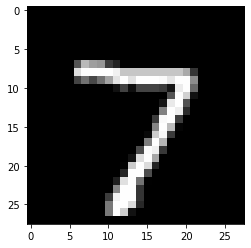

In [157]:
img, label = test_dataset[0]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

Label: 0 , Predicted: 2


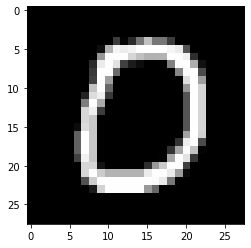

In [158]:
img, label = test_dataset[10]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

Label: 9 , Predicted: 4


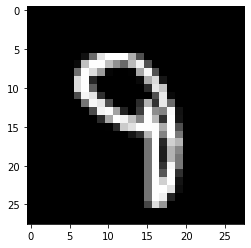

In [159]:
img, label = test_dataset[193]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

Label: 2 , Predicted: 5


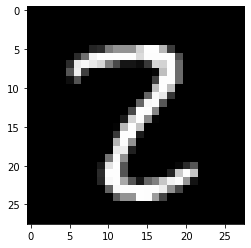

In [160]:
img, label = test_dataset[1839]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

Identifying where our model performs poorly can help us improve the model, by 
+ collecting more training data, 
+ increasing/decreasing the complexity of the model, and 
+ changing the hypeparameters.

As a final step, let's also look at the **overall loss and accuracy** of the model on the test set.

+ test set comes from the real world
+ validation set comes from a fraction of the training set

where is validation test accuracy?

In [161]:
test_loader = DataLoader(test_dataset, batch_size=256)
result = evaluate(model, test_loader)
result

{'val_loss': 2.352501392364502, 'val_acc': 0.08994140475988388}

**We expect test set accuracy is similar to the accuracy/loss on the validation set.** 

Very importantly, 

+ If not, we might need a better validation set that has similar data and distribution as the test set (which often comes from real world data).

In [162]:
test_dataset

Dataset MNIST
    Number of datapoints: 10000
    Root location: data/
    Split: Test
    StandardTransform
Transform: ToTensor()

## **Saving and loading the model**

Since we've trained our model for a long time and achieved a resonable accuracy, it would be a good idea to save the weights and bias matrices to disk, so that we can reuse the model later and avoid retraining from scratch. Here's how you can save the model.

In [163]:
torch.save(model.state_dict(), 'mnist-logistic.pth')

The `.state_dict` method returns an `OrderedDict` containing all the weights and bias matrices mapped to the right attributes of the model.

In [164]:
model.state_dict()

OrderedDict([('linear.weight',
              tensor([[ 0.0120, -0.0165, -0.0238,  ..., -0.0138,  0.0023,  0.0224],
                      [-0.0157, -0.0066,  0.0122,  ..., -0.0239,  0.0303, -0.0243],
                      [ 0.0097,  0.0288, -0.0013,  ..., -0.0222, -0.0165,  0.0135],
                      ...,
                      [ 0.0209,  0.0317, -0.0136,  ..., -0.0183,  0.0203,  0.0273],
                      [ 0.0110,  0.0045, -0.0268,  ..., -0.0278, -0.0140, -0.0198],
                      [-0.0127, -0.0297, -0.0210,  ...,  0.0177,  0.0232, -0.0147]])),
             ('linear.bias',
              tensor([ 0.0345, -0.0232, -0.0292, -0.0177, -0.0221,  0.0251, -0.0235, -0.0018,
                      -0.0273,  0.0002]))])

To load the model weights, we can instante a new object of the class `MnistModel`, and use the `.load_state_dict` method.

In [165]:
model2 = MnistModel()

In [166]:
model2.state_dict()

OrderedDict([('linear.weight',
              tensor([[ 0.0172, -0.0251,  0.0101,  ...,  0.0228, -0.0317,  0.0232],
                      [-0.0258, -0.0163, -0.0151,  ..., -0.0240,  0.0072, -0.0027],
                      [-0.0257,  0.0115,  0.0099,  ...,  0.0027,  0.0107, -0.0244],
                      ...,
                      [ 0.0195, -0.0303,  0.0205,  ...,  0.0031,  0.0192, -0.0104],
                      [ 0.0112,  0.0180,  0.0341,  ...,  0.0095, -0.0298, -0.0021],
                      [ 0.0237,  0.0101, -0.0210,  ..., -0.0304,  0.0306,  0.0231]])),
             ('linear.bias',
              tensor([ 0.0155,  0.0025,  0.0235, -0.0111,  0.0329, -0.0063,  0.0145,  0.0026,
                       0.0021, -0.0155]))])

In [167]:
evaluate(model2, test_loader)

{'val_loss': 2.3222739696502686, 'val_acc': 0.10957030951976776}

In [168]:
model2.load_state_dict(torch.load('mnist-logistic.pth'))
model2.state_dict()

OrderedDict([('linear.weight',
              tensor([[ 0.0120, -0.0165, -0.0238,  ..., -0.0138,  0.0023,  0.0224],
                      [-0.0157, -0.0066,  0.0122,  ..., -0.0239,  0.0303, -0.0243],
                      [ 0.0097,  0.0288, -0.0013,  ..., -0.0222, -0.0165,  0.0135],
                      ...,
                      [ 0.0209,  0.0317, -0.0136,  ..., -0.0183,  0.0203,  0.0273],
                      [ 0.0110,  0.0045, -0.0268,  ..., -0.0278, -0.0140, -0.0198],
                      [-0.0127, -0.0297, -0.0210,  ...,  0.0177,  0.0232, -0.0147]])),
             ('linear.bias',
              tensor([ 0.0345, -0.0232, -0.0292, -0.0177, -0.0221,  0.0251, -0.0235, -0.0018,
                      -0.0273,  0.0002]))])

Just as a sanity check, let's verify that this model has the same loss and accuracy on the test set as before.

In [169]:
test_loader = DataLoader(test_dataset, batch_size=256)
result = evaluate(model2, test_loader)
result

{'val_loss': 2.352501392364502, 'val_acc': 0.08994140475988388}